# Image Classification with XGBoost

In [ ]:
import pandas as pd
# import pydicom
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
# import tensorflow as tf
import os
import csv
import xgboost as xgb

from tqdm import tqdm
from glob import glob
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from skimage import io, transform
from sklearn.model_selection import RepeatedKFold
from sklearn.neighbors import KNeighborsClassifier


# from keras.wrappers.scikit_learn import KerasClassifier
# from keras.metrics import AUC
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
# from keras.layers.convolutional import Conv2D, MaxPooling2D
# from keras.constraints import maxnorm
# from keras.utils import np_utils
# from keras.preprocessing.image import ImageDataGenerator

### Load Dataset

In [ ]:
%%time

# Load the compressed array from disk
images_mini = np.load('CNN_Xs_downsample_forvgg16.npz')['data']

CPU times: user 10.7 s, sys: 1.19 s, total: 11.9 s
Wall time: 12.5 s


In [ ]:
# load the labels from disk
with open('CNN_labels_downsampled_forvgg16.csv', 'r') as file:
    reader = csv.reader(file)
    labels_mini = list(reader)[0]
    labels_mini = [int(x) for x in labels_mini]
    y_mini= np.array(labels_mini)

In [ ]:
print('images_mini.shape:', images_mini.shape)
print('\nnumber of labels:', len(labels_mini))
print('\nnumber of positive cancer cases:', sum(labels_mini))

images_mini.shape: (5600, 224, 224, 3)

number of labels: 5600

number of positive cancer cases: 600


### Normalize

In [ ]:
print('Original max pixel value:', images_mini.max())
print('Confirm min pixel value is 0:', images_mini.min())

Original max pixel value: 255.0
Confirm min pixel value is 0: 0.0


In [ ]:
#Normalize image pixel values
images_mini_norm = images_mini / images_mini.max() 

In [ ]:
print('New max pixel value:', images_mini_norm.max())
print('Confirm min pixel value is 0:', images_mini_norm.min())

New max pixel value: 1.0
Confirm min pixel value is 0: 0.0


### Reshape

In [ ]:
images_mini_norm.shape

(5600, 224, 224, 3)

In [ ]:
arr_mean = np.mean(images_mini_norm, axis=-1)
arr_mean.shape
resized_images_mini = np.expand_dims(arr_mean, axis=-1)
resized_images_mini.shape

(5600, 224, 224, 1)

In [ ]:
print('Original max pixel value:', resized_images_mini.max())
print('Confirm min pixel value is 0:', resized_images_mini.min())

Original max pixel value: 1.0
Confirm min pixel value is 0: 0.0


## Settings

In [ ]:
random_state = 1234

In [ ]:
random.seed(random_state)
# tf.random.set_seed(random_state)
np.random.seed(random_state)

### Inputs

In [ ]:
X= resized_images_mini
y = y_mini

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_train.shape

(4480, 224, 224, 1)

In [ ]:
# reshape
X_train = np.reshape(X_train, (len(X_train), -1))
X_test = np.reshape(X_test, (len(X_test), -1))

## Build Model

In [ ]:
param_dist = {
    'n_neighbors': [15, 20], #[3,5,7]
    'weights': ['distance'],#['uniform', 'distance'],
    'p': [1, 2],
    'algorithm': ['auto']#, 'ball_tree', 'kd_tree', 'brute']
}




In [ ]:
# create a XGBClassifier instance
knn = KNeighborsClassifier(n_jobs=-1)


In [ ]:
X_train.shape

(4480, 50176)

In [ ]:
y_train.shape

(4480,)

In [ ]:
grid_search = RandomizedSearchCV(
    knn, 
    param_distributions=param_dist, 
    cv=5,
    scoring='f1',
    # n_jobs=10,
    verbose=20,
    n_iter=100,
    return_train_score=True,
)

grid_search.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 4 is smaller than n_iter=100. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START algorithm=auto, n_neighbors=15, p=1, weights=distance.......
[CV 1/5; 1/4] END algorithm=auto, n_neighbors=15, p=1, weights=distance;, score=(train=1.000, test=0.000) total time=  25.3s
[CV 2/5; 1/4] START algorithm=auto, n_neighbors=15, p=1, weights=distance.......
[CV 2/5; 1/4] END algorithm=auto, n_neighbors=15, p=1, weights=distance;, score=(train=1.000, test=0.000) total time=  18.5s
[CV 3/5; 1/4] START algorithm=auto, n_neighbors=15, p=1, weights=distance.......
[CV 3/5; 1/4] END algorithm=auto, n_neighbors=15, p=1, weights=distance;, score=(train=1.000, test=0.000) total time=  19.7s
[CV 4/5; 1/4] START algorithm=auto, n_neighbors=15, p=1, weights=distance.......
[CV 4/5; 1/4] END algorithm=auto, n_neighbors=15, p=1, weights=distance;, score=(train=1.000, test=0.000) total time=  19.6s
[CV 5/5; 1/4] START algorithm=auto, n_neighbors=15, p=1, weights=distance.......
[CV 5/5; 1/4] END algorithm=auto, n

In [ ]:
model_name = 'knn'

# convert the results to a pandas DataFrame
cv_results = pd.DataFrame(grid_search.cv_results_)

# save the results to a CSV file
cv_results.to_csv(f'results/{model_name}_crossvalidation_results.csv', index=False)

In [ ]:
# print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

In [ ]:
len(params)

NameError: name 'params' is not defined

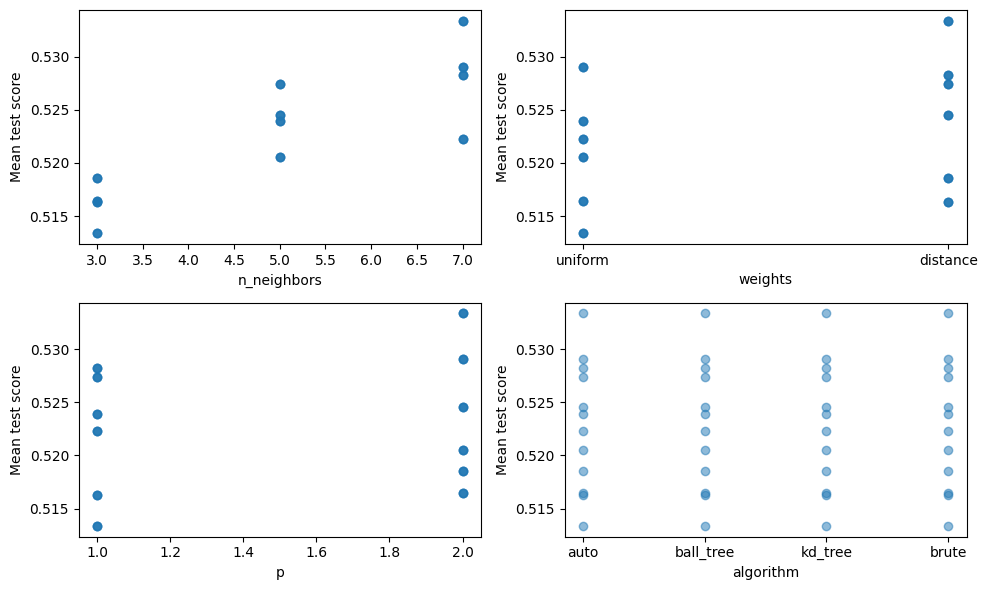

In [ ]:
params = grid_search.cv_results_['params']
scores = grid_search.cv_results_['mean_test_score']

# Plot the hyperparameters against their corresponding scores
plt.figure(figsize=(10, 6))
for i, param in enumerate(param_dist.keys()):
    plt.subplot(2, 2, i+1)
    plt.scatter([p[param] for p in params], scores, alpha=0.5)
    plt.xlabel(param)
    plt.ylabel('Mean test score')
plt.tight_layout()
plt.show()

### Scoring

In [ ]:
# grid_search.best_params_
hyperparam = {'weights': 'distance', 'p': 2, 'n_neighbors': 7, 'algorithm': 'auto'}

In [ ]:
tuned_clf = KNeighborsClassifier(
    # random_state=random_state,
    **hyperparam
)

In [ ]:
tuned_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7, weights='distance')

In [ ]:
train_roc = tuned_clf.score(X_train, y_train)
print(f"Train ROC_AUC score: {train_roc:.3f}")

# Evaluate the test accuracy
test_roc = tuned_clf.score(X_test, y_test)
print(f"Test ROC_AUC score: {test_roc:.3f}")

Train ROC_AUC score: 1.000
Test ROC_AUC score: 0.894


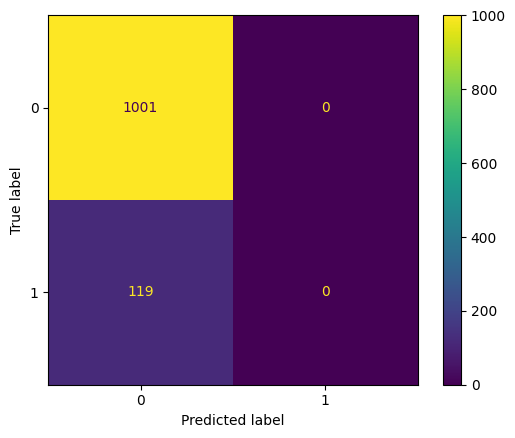

In [ ]:
y_pred_train = tuned_clf.predict(X_train)
y_pred_test = tuned_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=tuned_clf.classes_
)
disp.plot()
plt.show()

In [ ]:
from sklearn.metrics import f1_score
train_roc = f1_score(y_train, y_pred_train)
print(f"Train f1 score: {train_roc:.3f}")

# Evaluate the test accuracy
test_roc = f1_score(y_test, y_pred_test)
print(f"Test f1 score: {test_roc:.3f}")

Train f1 score: 1.000
Test f1 score: 0.000


In [ ]:
from sklearn.metrics import roc_auc_score
train_roc = roc_auc_score(y_train, y_pred_train)
print(f"Train ROC_AUC score: {train_roc:.3f}")

# Evaluate the test accuracy
test_roc = roc_auc_score(y_test, y_pred_test)
print(f"Test ROC_AUC score: {test_roc:.3f}")

Train ROC_AUC score: 1.000
Test ROC_AUC score: 0.500


In [ ]:
from sklearn.metrics import precision_score, recall_score

train_roc = precision_score(y_train, y_pred_train)
print(f"Train precision score: {train_roc:.3f}")

# Evaluate the test accuracy
test_roc = precision_score(y_test, y_pred_test)
print(f"Test precision score: {test_roc:.3f}")


train_roc = recall_score(y_train, y_pred_train)
print(f"Train recall score: {train_roc:.3f}")

# Evaluate the test accuracy
test_roc = recall_score(y_test, y_pred_test)
print(f"Test recall score: {test_roc:.3f}")

Train precision score: 1.000
Test precision score: 0.000
Train recall score: 1.000
Test recall score: 0.000


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
train_roc = recall_score(y_train, y_pred_train)
print(f"Train recall score: {train_roc:.3f}")

# Evaluate the test accuracy
test_roc = recall_score(y_test, y_pred_test)
print(f"Test recall score: {test_roc:.3f}")

In [ ]:

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=tuned_clf.classes_
)
disp.plot()
plt.show()

In [ ]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3999
           1       1.00      1.00      1.00       481

    accuracy                           1.00      4480
   macro avg       1.00      1.00      1.00      4480
weighted avg       1.00      1.00      1.00      4480



In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1001
           1       0.00      0.00      0.00       119

    accuracy                           0.89      1120
   macro avg       0.45      0.50      0.47      1120
weighted avg       0.80      0.89      0.84      1120



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
